In [48]:
# data import for 2005 data
import pandas as pd

data_2005 = pd.read_csv('/Users/colden/Documents/VSCode/Emos_Classification/Environment_Data_2005_cleaned.csv')

data_2005['description'] = data_2005['name'] + ' ' + data_2005['mission'].fillna('')
data_2005['data_year'] = 2005


print('\n\n Value Counts, 0 is not env, 1 is env: ')
print(data_2005['env'].value_counts())




 Value Counts, 0 is not env, 1 is env: 
env
0    20182
1     7169
Name: count, dtype: int64


In [49]:
# data import/cleaning for 2017/2018 data
import pandas as pd

file_path = '/Users/colden/Documents/VSCode/Emos_Classification/Environment_Data_2015_2016_cleaned.csv'
data_2017 = pd.read_csv(file_path)
data_2017['data_year'] = 2017

# create ntee1 column
data_2017['ntee1'] = data_2017['nteecc'].str[0]

data_2017['mission'] = data_2017['mission'].str.replace('SEE SCHEDULE O', '')
data_2017['description'] = data_2017['name'] + ' ' + data_2017['mission']


print('\n\n Value Counts, 0 is not env, 1 is env: ')
print(data_2017['env'].value_counts())



 Value Counts, 0 is not env, 1 is env: 
env
0    21010
1     4763
Name: count, dtype: int64


In [50]:
# set data

# drop a percent of a given ntee1 for 0 vals only
def drop_perc_ntee1(data, ntee1, percent):
    selected_rows = data[(data['ntee1'] == ntee1) & (data['env'] == 0)]
    drop_rows = selected_rows.sample(frac=percent, random_state=1)
    data_dropped = data.drop(drop_rows.index)
    # print(data[data['ntee1'] == 'S']['env'].value_counts()) # prior to drop
    # print(data_dropped[data_dropped['ntee1'] == 'S']['env'].value_counts()) # after drop
    return data_dropped


data = pd.concat([data_2005, data_2017], ignore_index=True)
data = drop_perc_ntee1(data, 'S', 0.95)
data.reset_index(drop=True, inplace=True) # this NEEDS to be called after drop_perc_ntee1!!! otherwise everything breaks (can't index later on with functions) # wow I'm slow
data.insert(0, 'row_num', data.index)


print(data['env'].value_counts())

env
0    22519
1    11932
Name: count, dtype: int64


In [51]:
# clean data
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
#nltk.download('stopwords')

# lematize function - taken from IBM: https://www.ibm.com/topics/stemming-lemmatization#:~:text=The%20practical%20distinction%20between%20stemming,be%20found%20in%20the%20dictionary.
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN

def lemmatize_passage(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    lemmatized_sentence = ' '.join(lemmatized_words)
    return lemmatized_sentence

# put all of the cleaned data into a corpus
def data_to_corpus(data):
    corpus = []
    for i in range(len(data)):
        row = data.iloc[i]
        summary = row['description'].lower()
        summary = summary.split()
        clean_summary = ' '.join(summary)
        corpus.append(clean_summary)
    return corpus

def remove_stopwords(data_to_remove_from):
    stop_words = set(stopwords.words('english'))
    stop_words.add('s')
    stop_words.add('nan')
    # Remove stopwords from the description
    data_to_remove_from['description'] = data_to_remove_from['description'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words]))

# main clean data function
def clean_data(data):
    data['description'] = data['description'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
    remove_stopwords(data) # no return value, modifies data in place
    data['description'] = data['description'].apply(lemmatize_passage)
    corpus = data_to_corpus(data)
    return corpus


corpus = clean_data(data)

print("/n/n Lemmatized Data: ")
print(data['description'][0])
print(corpus[1])

/n/n Lemmatized Data: 
PARTNERSHIP SUSTAINABLE METHOW PROMOTE SUSTAINABLE ECONOMIC ACTIVITY METHOW VALLEY
landscape architecture foundation promote education research landscape architecture


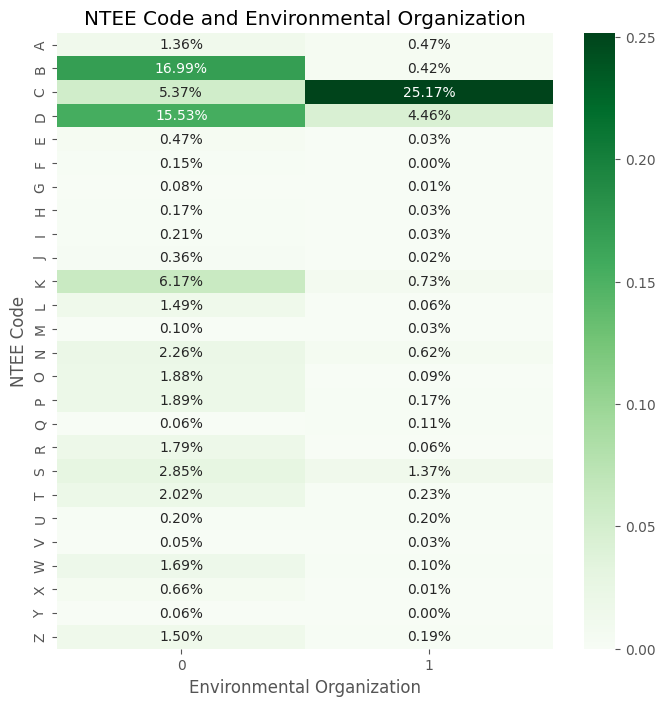

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

confusion_matrix_predictedvactual = pd.crosstab(data['ntee1'], data['env'])

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix_predictedvactual/len(data), annot=True, cmap='Greens', fmt='.2%')
#sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('NTEE Code and Environmental Organization')
plt.xlabel('Environmental Organization')
plt.ylabel('NTEE Code')

plt.show()


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
input_size = 1500 # number of words to keep -- note that this is also what is fed into the neural network as input size

vectorizer = TfidfVectorizer(max_features=input_size, min_df=3, max_df=0.8) #max features is number of words to keep, min_df is min # of documents a word must appear in, max_df is max percentage of documents a word can appear in
X = vectorizer.fit_transform(corpus).toarray()

y = data.loc[:, 'env'].values # env col



In [54]:
import numpy as np
from sklearn.model_selection import train_test_split

corpus_indices = np.arange(len(corpus))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, corpus_indices, test_size=0.1, random_state=0)

# How to print training data corresponding to corpus
# print(idx_test[0]) # index of first test data
# print(corpus[idx_test[0]]) # mechanism to print the first test data


In [55]:
import torch
import torch.nn as nn
from torch.nn import functional as F

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()



In [56]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(input_size) # number of words in the vectorized data
output_size = 2 # binary classification
hidden_size = 750 # number of neurons in the hidden layer

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)

model = Net()

import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
loss_fn = nn.NLLLoss() # CrossEntropyLoss() is the same as NLLLoss() with log_softmax ?



torch.Size([31005, 1500]) torch.Size([31005])
torch.Size([3446, 1500]) torch.Size([3446])
1500


In [57]:
epochs =  70
losses = []
testing = []
accuracy = None
for epoch in range(epochs):
    optimizer.zero_grad()
    # Y_pred = model(X_train, ntee_train)
    Y_pred = model(X_train)
    loss = loss_fn(Y_pred, y_train.long())
    losses.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()


    if epoch % 10 == 0:
        print(f'Epoch {epoch} / {epochs}, Loss: {loss.item()}')
        print(f'Accuracy on test data at Epoch {epoch}: {accuracy}%')

    model.eval()
    with torch.no_grad():
        # Assuming X_test is your test data and y_test are the true labels
        Y_test_pred = model(X_test)
        # Convert the predictions to class labels
        _, predicted_labels = torch.max(Y_test_pred, 1)

        # Calculate the number of correct predictions
        correct_predictions = (predicted_labels == y_test).sum().item()
        total_predictions = y_test.size(0)
        accuracy = correct_predictions / total_predictions  # Accuracy as a percentage
        testing.append(accuracy)

    # Switch back to training mode
    model.train()


# (21880x1502 and 1500x500)
# so, multiply with 1502 columns and 1502 rows is ok -- input_size vars will be the number of rows

Epoch 0 / 70, Loss: 0.6876693367958069
Accuracy on test data at Epoch 0: None%
Epoch 10 / 70, Loss: 0.6065457463264465
Accuracy on test data at Epoch 10: 0.6439349970980848%
Epoch 20 / 70, Loss: 0.47673046588897705
Accuracy on test data at Epoch 20: 0.6445153801508996%
Epoch 30 / 70, Loss: 0.34003064036369324
Accuracy on test data at Epoch 30: 0.8934997098084736%
Epoch 40 / 70, Loss: 0.24625371396541595
Accuracy on test data at Epoch 40: 0.912652350551364%
Epoch 50 / 70, Loss: 0.18256449699401855
Accuracy on test data at Epoch 50: 0.9109112013929194%
Epoch 60 / 70, Loss: 0.15136992931365967
Accuracy on test data at Epoch 60: 0.9132327336041788%


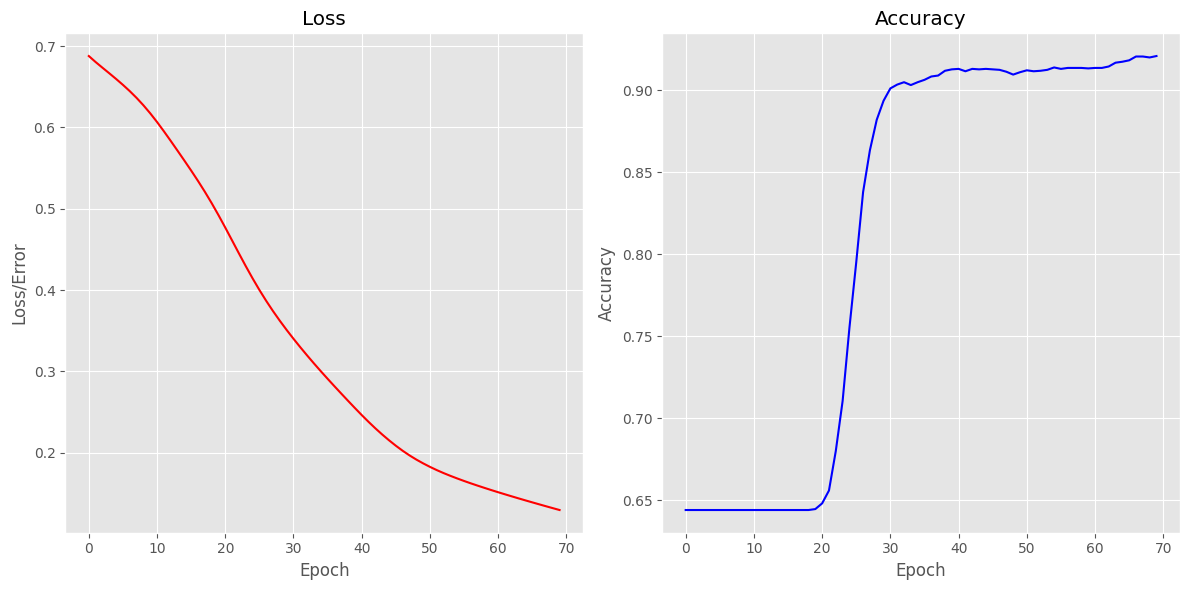

In [58]:
plt.style.use('ggplot')
# loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), losses, color = 'red')
plt.ylabel("Loss/Error")
plt.xlabel('Epoch')
plt.title("Loss")

# accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), testing, color = "blue")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy")

plt.tight_layout()
plt.show()

In [59]:


threshold = 0.2 # .5 change to 9/53 --> only 2 more identified, but many more cases # 0.2 seems to be pretty good

false_neg_list, false_pos_list, correct_list, uncertain_list = [], [], [], []
false_neg, false_pos, correct, uncertain = 0, 0, 0, 0
y_predictions = []
y_actual = []
true_pos, true_neg = 0, 0 # sum to 'correct'

with torch.no_grad():
   for i, X_test_row in enumerate(X_test):
      y_val = model.forward(X_test_row)
      y_predictions.append(y_val)
      predicted_class = y_val.argmax().item()
      actual_class = y_test[i].item()
      y_actual.append(actual_class)

      if abs(y_val[0].item() - y_val[1].item()) < threshold:
            #print(f'{i+1}. {str(y_val)}, predicted {predicted_class}, actual {actual_class}')
            uncertain_list.append(i)
            uncertain += 1
      elif predicted_class == actual_class:
         correct_list.append(i)
         correct += 1
         if predicted_class == 0:
            true_neg += 1
         else:
            true_pos += 1
      elif predicted_class != actual_class:
         if predicted_class == 0:
            false_neg_list.append(i)
            false_neg += 1
         else:
            false_pos_list.append(i)
            false_pos += 1



print(f'Correct: {correct}, False: {false_neg + false_pos}, Uncertain: {uncertain}')
print(f'False prediction 0: {false_neg}, False prediction 1: {false_pos}')

print(f'Accuracy: {(correct + uncertain) / (correct + false_neg + false_pos + uncertain)}')
print(f'Precision: {true_pos / (true_pos + false_pos)}')
print(f'Recall: {true_pos / (true_pos + false_neg)}')

# currently, TfidfVectorizer is used to train the model. However, this is a bag of words model, which does not take into account the context of the words.
# This is a limitation of the model. A better model might be a word2vec, BERT, FastText, Glove, etc. model, which takes into account the context of the words.
# would also be nice to see which tensor goes with which word

Correct: 3146, False: 247, Uncertain: 53
False prediction 0: 136, False prediction 1: 111
Accuracy: 0.928322692977365
Precision: 0.9055319148936171
Recall: 0.8866666666666667


In [60]:
# predictions for the ntee model
np.set_printoptions(threshold=500, linewidth=200, edgeitems=30)

# given a test index, return the corresponding row in 'data'
def get_from_testdata(position):
    row = data.loc[idx_test[position]] # get the row in 'data' corresponding to the test index
    return row

# print(idx_test[0])
# print(data.loc[31178])
# get_from_testdata(0)
# print()

# input a row from 'data' to convert to tensor (with ntee codes)
def predict_nteeincl(row_index):
    input_text = vectorizer.transform([data['description'][row_index]]).toarray()
    input_matrix = torch.from_numpy(input_text).float()
    output = model(input_matrix)
    return str(output) + ' , predicted:' + str(output.argmax().item())

# print(predict_nteeincl(0)) # get prediction

# pass in an array of indices, return the corresponding rows in 'data'
def return_rows(array):
    df_list = []
    for test_i in array:
        data_i = get_from_testdata(test_i)
        df_list.append(data_i)
    return_df = pd.concat(df_list, axis=1).transpose()
    return return_df


In [61]:
import os
directory = 'noNTEEoutputdirectory'
if not os.path.exists(directory):
    os.makedirs(directory)

return_rows(false_neg_list).to_csv(f'{directory}/false_neg.csv', index=False)
return_rows(false_pos_list).to_csv(f'{directory}/false_pos.csv', index=False)
return_rows(correct_list).to_csv(f'{directory}/correct.csv', index=False)
try:
    return_rows(uncertain_list).to_csv(f'{directory}/uncertain.csv', index=False)
except ValueError:
    print('No uncertain predictions')
    
# create prediction_result column in 'data' to show prediction results
def update_prediction_result(position_list, result):
    for position in position_list:
        index = idx_test[position]
        data.loc[index, 'Prediction_Result'] = result

update_prediction_result(correct_list, "correct")
update_prediction_result(false_neg_list, "false_neg")
update_prediction_result(false_pos_list, "false_pos")
update_prediction_result(uncertain_list, "uncertain")

data.to_csv(f'{directory}/final_data.csv')

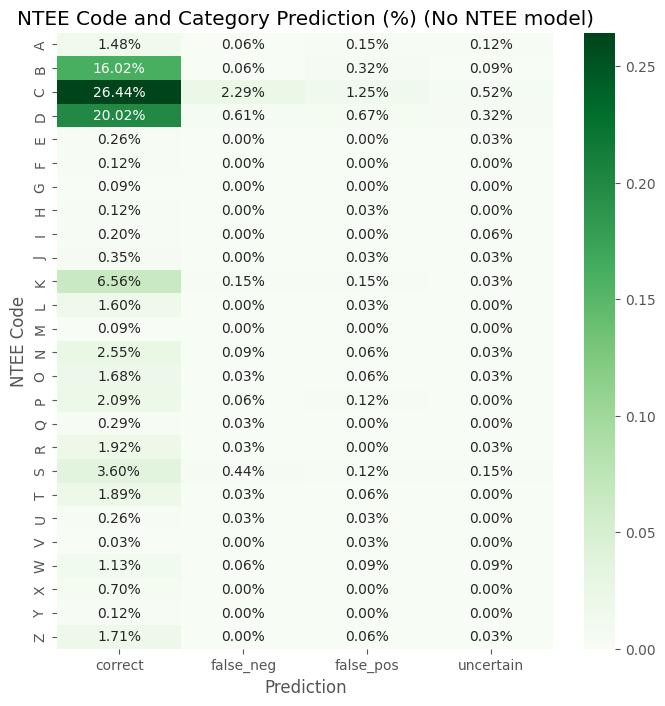

In [62]:
confusion_matrix_predictedvactual = pd.crosstab(data['ntee1'], data['Prediction_Result'])

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix_predictedvactual/len(y_test), annot=True, cmap='Greens', fmt='.2%')
# sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('NTEE Code and Category Prediction (%) (No NTEE model)')
plt.xlabel('Prediction')
plt.ylabel('NTEE Code')

plt.show()

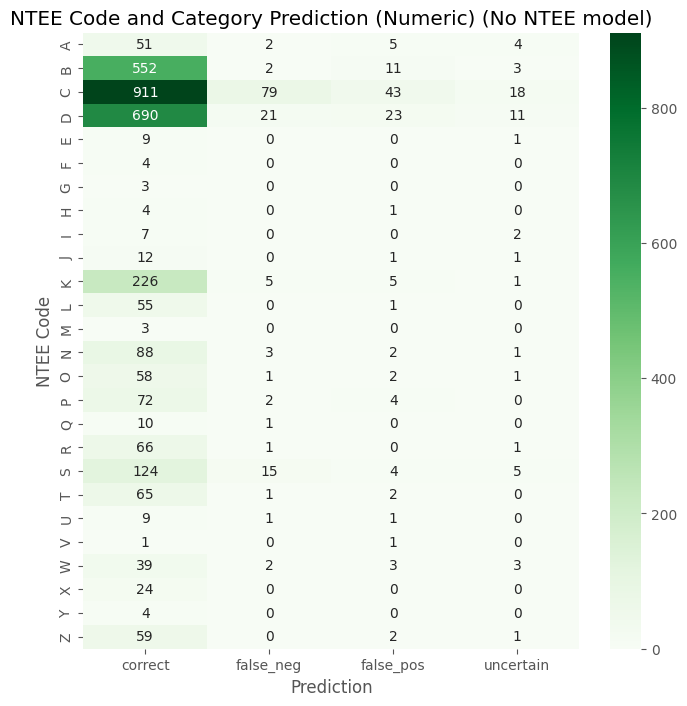

In [63]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix_predictedvactual, annot=True, cmap='Greens', fmt='g')

plt.title('NTEE Code and Category Prediction (Numeric) (No NTEE model)')
plt.xlabel('Prediction')
plt.ylabel('NTEE Code')

plt.show()

Index(['row_num', 'ein', 'env', 'geo', 'tradeassoc', 'name', 'mission',
       'fisyr', 'ntee1', 'nteecc', 'state', 'zip5', 'ntee2007a',
       'tradeassoc.1', 'orig_description', 'description', 'data_year',
       'tax_period', 'desc_2', 'desc_3', 'Prediction_Result'],
      dtype='object')


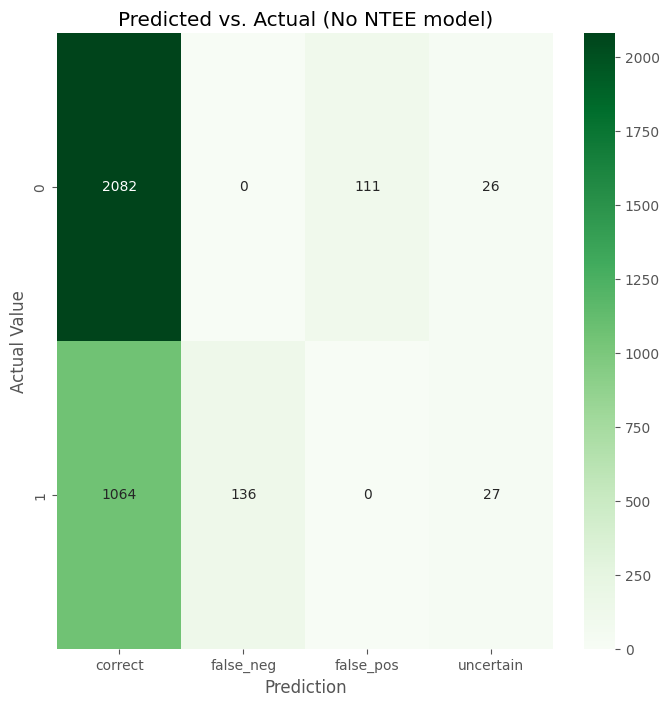

In [64]:
print(data.keys())

confusion_matrix_predictedvactual = pd.crosstab(data['env'], data['Prediction_Result'])

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix_predictedvactual, annot=True, cmap='Greens', fmt='g')
# sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Predicted vs. Actual (No NTEE model)')
plt.xlabel('Prediction')
plt.ylabel('Actual Value')

plt.show()

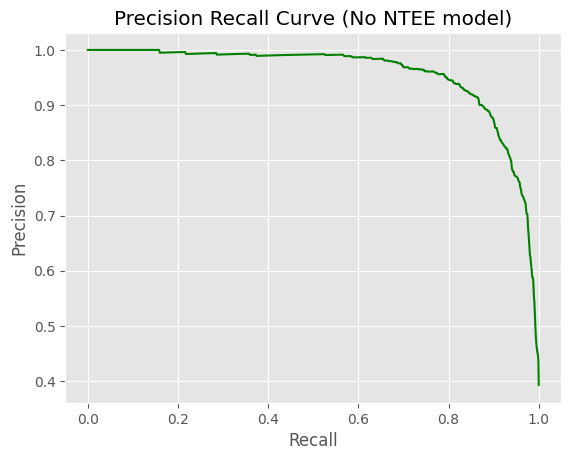

For a recall of _0.85_ the corresponding (interpolated) precision is 0.9205613634024558


In [65]:
from sklearn.metrics import precision_recall_curve

probabilities = torch.softmax(torch.stack(y_predictions), dim=1)[:, 1].detach().numpy()

precision, recall, trash_arr = precision_recall_curve(y_actual, probabilities)


sns.lineplot(x = recall, y = precision, color = 'green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve (No NTEE model)')
plt.show()

recall_val = 0.85
corresponding_precision = np.interp(recall_val, recall[::-1], precision[::-1]) # reverse the arrays so they are in increasing order, then do the interpolate function

print(f"For a recall of _{recall_val}_ the corresponding (interpolated) precision is {corresponding_precision}")

In [66]:
torch.save(model.state_dict(), f'{directory}/model.pt')

In [74]:
def make_predictions(vectorized_text):
   y_final_predictions = []
   with torch.no_grad():
      for X_row in vectorized_text:
         y_val = model.forward(X_row)
         y_final_predictions.append(y_val)
   return y_final_predictions

def predict(data_to_predict):
    corpus_preprocessed = clean_data(data_to_predict) # pass in a dataframe with a 'description' column
    X_vars = vectorizer.transform(corpus_preprocessed).toarray() # vectorize data to pass into model # Note: IF SAMPLE IS TOO SMALL, THIS WILL BREAK (not enough words to vectorize to proper matrix shape)
    X_vars = torch.from_numpy(X_vars).float() # convert to tensor
    predictions = make_predictions(X_vars)
    return predictions

def predictions_to_df(predictions, data_to_predict):
   for i, prediction in enumerate(predictions):
      prediction_val = prediction.argmax().item()
      data_to_predict.loc[i, 'Prediction'] = prediction_val
   return data_to_predict

# main prediction function -- pass in a df, make predictions, and return a df with predictions
# passed in df should have a 'description' column -- this is what predictions will be made on.
def make_predictions_from_df(data_to_predict):
   predictions = predict(data_to_predict)
   print([x.argmax().item() for x in predictions])
   predictions_output_df = predictions_to_df(predictions, data_to_predict)

   cols = list(predictions_output_df.columns)
   cols.insert(3, cols.pop(cols.index('Prediction'))) 
   predictions_output_df = predictions_output_df.loc[:, cols] # move prediction to the front of the df for easier visibility
   return predictions_output_df


data_to_predict = pd.read_csv('/Users/colden/Documents/VSCode/Emos_Classification/noNTEEoutputdirectory/correct.csv')
print(make_predictions_from_df(data_to_predict).head())



[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 

In [78]:
# make predictions on a given dataframe

data = data
data['description'] = data['description']
df_predictions = make_predictions_from_df(data)
df_predictions.to_csv(f'{directory}/predictions.csv')


[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 